# Providing custom stimuli

Follow this notebook to learn how to use our models for generating hypothesis about neural computations with custom stimuli.

## Example dataset

We take the public [Moving MNIST](https://www.cs.toronto.edu/~nitish/unsupervised_video/) sequence dataset as an example for a custom stimulus dataset.
Moving MNIST consists of short grey-scale videos of numbers from 1-10 which move in arbitrary directions. The dataset entails 10,000 sequences of 20 frames each. Individual frames are 64x64 pixels in height and width.

In [1]:
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [2]:
sequences = load_moving_mnist()

In [3]:
# the whole dataset has dims (n_sequences, n_frames, height, width)
sequences.shape

(10000, 20, 64, 64)

In [4]:
example_sequence_ids = np.random.randint(0, high=sequences.shape[1], size=3)

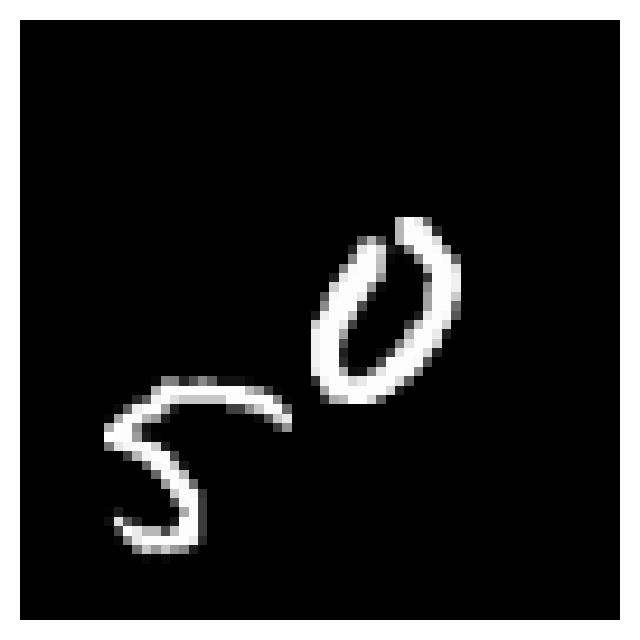

In [5]:
animation = flyvision.animations.Imshow(sequences, cmap=plt.cm.binary_r)
animation.animate_in_notebook(samples=example_sequence_ids)

## BoxEye rendering

##### Rendering cartesian images to hexagonal lattice

We translate cartesian frames into receptor activations by placing simulated photoreceptors in a two-dimensional hexagonal array in pixel space (blue dots below), 31 columns across resulting in 721 columns in total, spaced 13 pixels apart. The transduced luminance at each photoreceptor is the greyscale mean value in the 13×13-pixel region surrounding it (black boxes).

In [1]:
import flyvision

In [2]:
receptors = flyvision.rendering.BoxEye(extent=15, kernel_size=13)

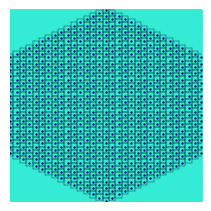

In [3]:
fig = receptors.illustrate()

### Render a single frame

To illustrate, this is what rendering a single frame looks like.

In [1]:
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [2]:
sequences = load_moving_mnist()

In [3]:
single_frame = sequences[0, 0]

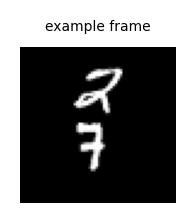

In [4]:
fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[1, 1], fontsize=5)
ax = flyvision.plots.plt_utils.rm_spines(ax)
ax.imshow(single_frame, cmap=plt.cm.binary_r)
_ = ax.set_title('example frame', fontsize=5)

In [5]:
# the rendering uses pytorch native Conv2d module so it can be executed on GPU and fast
# we first move the frame to GPU
single_frame = torch.Tensor(single_frame)

In [6]:
# because the inputs to the receptors instance must have four dimensions (samples, frames, height, width),
# we create two empty dimensions for samples and frames
single_frame = single_frame[None, None]

In [7]:
single_frame.shape

torch.Size([1, 1, 64, 64])

In [8]:
# to render the single frame we simply call the instance
# this automatically rescales the frame to match the receptor layout as illustrated above
# and then places the average pixel value of the 13x13 boxes at the receptor positions
receptors = flyvision.rendering.BoxEye()
rendered = receptors(single_frame)

In [9]:
# the 721 receptor coordinates are implicitly given in the last dimension
# they correspond to sorted hexagonal coordinates (u-coordinate, v-coordinate, value)
rendered.shape

torch.Size([1, 1, 1, 721])

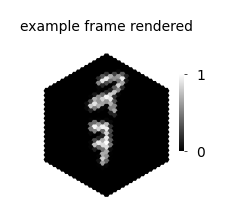

In [10]:
# the rendered frame is a slightly blurred version of the example
fig, ax, _ = flyvision.plots.plots.quick_hex_scatter(
    rendered.squeeze(), vmin=0, vmax=1, cbar_x_offset=0, fontsize=5
)
_ = ax.set_title("example frame rendered", fontsize=5)

In [19]:
# Disclaimer: thinking in hex coordinates can be unfamiliar.
# Therefore, we circumvent dealing with them explicitly.
# Still - to understand how the above plot infers the pixel-plane coordinates 
# from the implicit hexagonal coordinates, you can inspect the following code.

In [20]:
# # we can explicitly create sorted hex-coordinates from the integer radius of the hexagonal grid
# # for a regular hexagonal lattice, the radius is uniquely determined from the number of hexagons

# radius = flyvision.utils.hex_utils.get_hextent(rendered.shape[-1])

# # here we create integer u, v coordinates, and we stick to the same function and convention 
# # everywhere in the code
# u, v = flyvision.utils.hex_utils.get_hex_coords(radius)

# # we transform them to pixel coordinates using our convention
# x, y = flyvision.utils.hex_utils.hex_to_pixel(u, v)

# # and can just scatter them to be back at the photoreceptor layout
# fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[2, 2], fontsize=5)
# ax.scatter(x, y, s=0.5)

## Render a whole dataset to disk

We save rendered sequences to disk to retrieve them faster at runtime.

We will use our library datamate here because it provides a powerful interface for writing and reading arrayfiles.

In [1]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [25]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [27]:
moving_mnist_rendered = RenderedData(
    dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3])
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.07it/s]


In [28]:
# this is how we can retrieve the sequences from the disk into memory
rendered_sequences = moving_mnist_rendered.sequences[:]

In [29]:
rendered_sequences.shape

(4, 20, 1, 721)

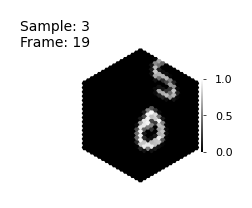

In [30]:
animation = flyvision.animations.HexScatter(rendered_sequences, vmin=0, vmax=1)
animation.animate_in_notebook()

In [30]:
# Note, to delete a Directory, e.g. to change the __init__ and reinstantiate,
# run moving_mnist_rendered.rmtree("y").

## Create a sequence dataset

Next we create a Pytorch dataset for loading the sequences.

In [2]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist
from flyvision.datasets.base import SequenceDataset

In [3]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

We create a generic interface for custom datasets to make dataloading consistent---this interface can tell the sampler what the framerate, the integration time steps, durations for pre-, and post grey-scale stimulation, and the number of sequences are.

In this case, we inherit a SequenceDataset, that also obeys (and extends) the interface of Pytorch's Dataset.

In [4]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [5]:
data = CustomStimuli(dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3]))

In [6]:
data[0].shape

torch.Size([84, 1, 721])

<IPython.core.display.Javascript object>


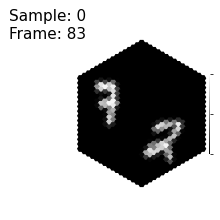

In [7]:
animation = flyvision.animations.HexScatter(data[0][None], vmin=0, vmax=1)
animation.animate_in_notebook()

## Compute model responses to custom stimuli

Now, we can compute model responses across individual models or the whole ensemble to our custom stimulus.

In [3]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist
from flyvision.datasets.base import SequenceDataset
from flyvision.utils.activity_utils import LayerActivity
from flyvision.animations import StimulusResponse

In [5]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [6]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [7]:
data = CustomStimuli(dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3]))

To select a network from the ensemble of 50 pretrained networks, let's see what our options are.

Paths to pretrained models from the ensemble end with four digit numbers which are sorted by task error (0-49 from best to worst).

In [8]:
sorted(
    [
        p.relative_to(flyvision.results_dir)
        for p in (flyvision.results_dir / "opticflow/000").iterdir()
        if p.name.isnumeric()
    ]
)

[PosixPath('opticflow/000/0000'),
 PosixPath('opticflow/000/0001'),
 PosixPath('opticflow/000/0002'),
 PosixPath('opticflow/000/0003'),
 PosixPath('opticflow/000/0004'),
 PosixPath('opticflow/000/0005'),
 PosixPath('opticflow/000/0006'),
 PosixPath('opticflow/000/0007'),
 PosixPath('opticflow/000/0008'),
 PosixPath('opticflow/000/0009'),
 PosixPath('opticflow/000/0010'),
 PosixPath('opticflow/000/0011'),
 PosixPath('opticflow/000/0012'),
 PosixPath('opticflow/000/0013'),
 PosixPath('opticflow/000/0014'),
 PosixPath('opticflow/000/0015'),
 PosixPath('opticflow/000/0016'),
 PosixPath('opticflow/000/0017'),
 PosixPath('opticflow/000/0018'),
 PosixPath('opticflow/000/0019'),
 PosixPath('opticflow/000/0020'),
 PosixPath('opticflow/000/0021'),
 PosixPath('opticflow/000/0022'),
 PosixPath('opticflow/000/0023'),
 PosixPath('opticflow/000/0024'),
 PosixPath('opticflow/000/0025'),
 PosixPath('opticflow/000/0026'),
 PosixPath('opticflow/000/0027'),
 PosixPath('opticflow/000/0028'),
 PosixPath('op

In [9]:
# We use the NetworkView class to point to a model. This object can implement plots plus methods to initialize network,
# stimuli etc. 
network_view = flyvision.network.NetworkView(flyvision.results_dir / "opticflow/000/0000")

In [10]:
# to load the Pytorch module with pretrained parameters
network = network_view.init_network(chkpt="best_chkpt")

In [11]:
movie_input = data[0]

In [12]:
movie_input.shape

torch.Size([84, 1, 721])

We initialize the network at a stationary state, to remove transient responses due to stimulus onset from functional stimulus responses like motion detection. The network provides two methods for stationary state computation `network.fade_in_state` and `network.steady_state`. We use `fade_in_state` here, which slowly ramps up
the intensity of the first frame in the sequence (minimizes transient response but must be computed for each individual sequence). The method `steady_state` computes a stationary state which can be used for all sequences by providing a whole-field grey-scale stimulus (but it does not get rid of a transient response).

In [13]:
stationary_state = network.fade_in_state(1.0, data.dt, movie_input[0][None])

A convenient way to obtain network responses is to call `network.simulate`
which calls the forward function of the Pytorch module without tracking gradients
(it provides a simpler interface than `network.forward` because it already maps stimulus to receptors using the `network.stimulus` attribute).

In [14]:
# For analysis, we move the returned tensor to cpu.
responses = network.simulate(movie_input[None], data.dt, initial_state=stationary_state).cpu()

In [15]:
responses.shape

torch.Size([1, 84, 45669])

`LayerActivity` is an interface to the response tensor of 45k cells that allows dict- and attribute-style access to the responses of individual cell types and to the responses of their central cells.

In [16]:
responses = LayerActivity(responses, network.connectome, keepref=True)

In [17]:
cell_type = "T4c"

The stimulus on the left, and the response on the right described by passive point neuron voltage dynamics. Cells depolarize (red) and hyperpolarize (blue) in response to the stimulus. A single "hexal" corresponds to one neuron of the cell type.

<IPython.core.display.Javascript object>


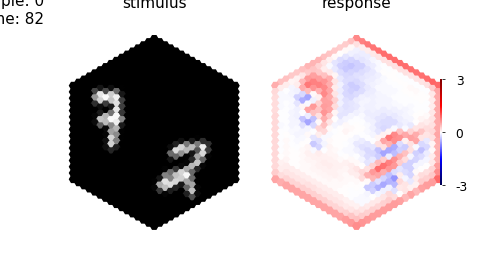

In [18]:
anim = StimulusResponse(
    movie_input[None],
    responses[cell_type][:, :, None]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::2])

Let's take a look at the central cell response over time.

In [19]:
n_frames = movie_input.shape[0]
time = np.arange(0, n_frames * data.dt, data.dt)

<IPython.core.display.Javascript object>


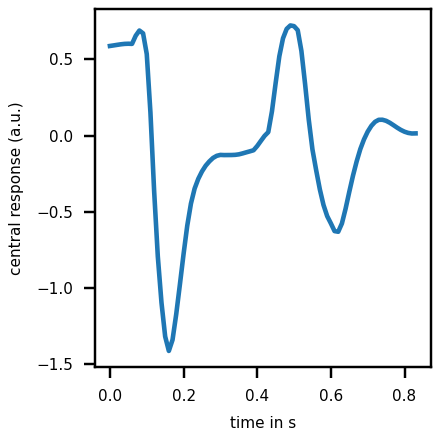

Text(0, 0.5, 'central response (a.u.)')

In [21]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
ax.plot(time, responses.central[cell_type].squeeze())
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("central response (a.u.)", fontsize=5)

## Computing maximally excitatory stimuli across a dataset

Lets find the maximally excitatory sequence from the Moving MNIST dataset for the central cell of particular cell type.

In [1]:
from os import PathLike
from datamate import Directory, root
import numpy as np
import torch
import matplotlib.pyplot as plt

import flyvision
from flyvision.datasets.base import SequenceDataset
from flyvision.utils.activity_utils import LayerActivity

# path to where moving mnist will be stored for this example
moving_mnist_path = flyvision.root_dir / "mnist_test_seq.npy"
example_sequence_ids = [7270,  860, 5390]

In [2]:
%matplotlib notebook

In [3]:
# top-level directory to store the rendered data
rendered_data_dest = flyvision.root_dir / "custom_stimuli"

# the Directory class is a smart pointer to a specific directory
# on the filesystem

@root(rendered_data_dest) # to tell where the Directory-tree starts
class RenderedData(Directory):
    
    class Config(dict):
        path: PathLike
    
    def __init__(self, config: Config):
        
        # Here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # This code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = np.load(self.config.path)
        sequences = np.transpose(sequences, (1, 0, 2, 3)) / 255.
        receptors = flyvision.rendering.BoxEye()
        
        rendered_sequences = []
        for sequence in sequences:
            rendered_sequences.append(receptors(sequence[None]).cpu().numpy())
        
        # datamate works best with numpy arrays
        rendered_sequences = np.array(rendered_sequences)    
                    
        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences 

In [4]:
class CustomStimuli(SequenceDataset):
    
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, path):
        self.dir = RenderedData(dict(path=path))
        self.sequences = torch.permute(torch.Tensor(self.dir.sequences[:]), (0, 2, 1, 3))
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [5]:
data = CustomStimuli(moving_mnist_path)

In [7]:
# let's look at the best task-performing model
network_view = flyvision.network.NetworkView(flyvision.results_dir / "opticflow/000/0000")

In [8]:
network = network_view.init_network()

We limit it here to the first 100 of 10_000 sequences to not wait for too long. The sequences to take into account can be controlled using the `indices` argument.

In [54]:
stimuli, responses = [], []

for stim, response in network.stimulus_response(data, 1/100, indices=np.arange(100)):
    stimuli.append(stim)
    responses.append(response)
    
stimuli = np.array(stimuli)
responses = np.array(responses)

In [55]:
responses = LayerActivity(responses, network.connectome, keepref=True)

In [56]:
maximally_excitatory_seq_id = np.argmax(responses.central[cell_type].max(axis=(2)).squeeze())

In [57]:
maximally_excitatory_seq_id

56

<IPython.core.display.Javascript object>


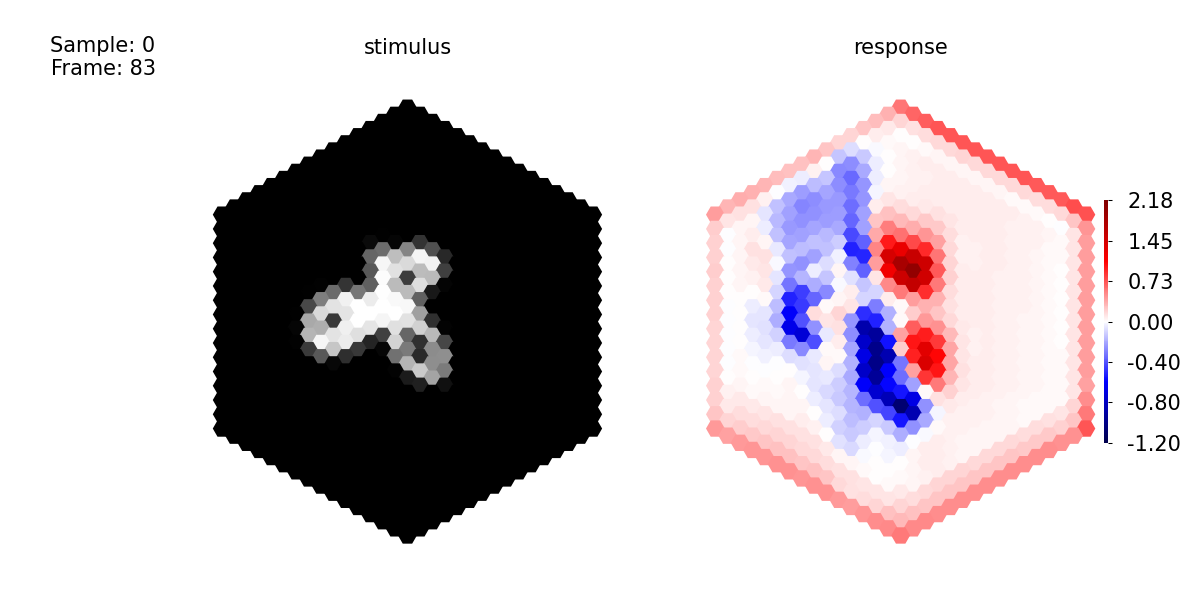

In [58]:
anim = flyvision.animations.activations.StimulusResponse(
    stimuli[maximally_excitatory_seq_id],
    responses[cell_type][maximally_excitatory_seq_id][:, :, None]
)
anim.animate_in_notebook()

Let's validate that this stimulus gives a higher central cell response than all others.

<IPython.core.display.Javascript object>


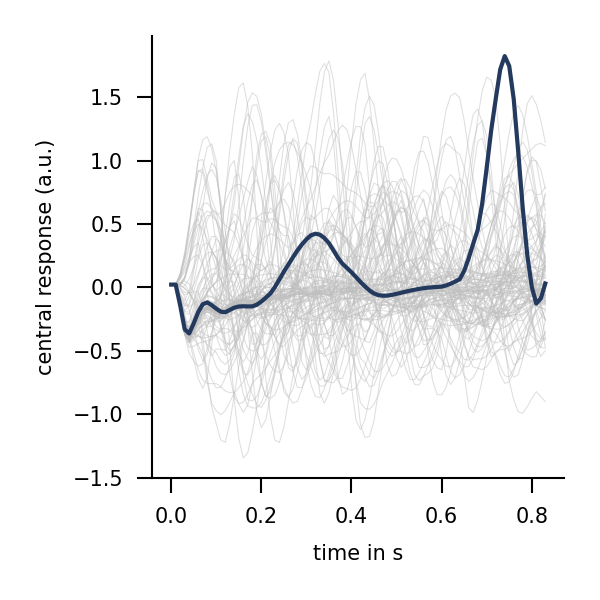

In [59]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
for _id, response in enumerate(responses.central[cell_type]):
    mei = _id == maximally_excitatory_seq_id
    ax.plot(
        time,
        response.squeeze(),
        c="#23395d" if mei else "0.75",
        lw=1.0 if mei else 0.25,
        alpha=1.0 if mei else 0.5,
        zorder=10 if mei else 0
    )
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("central response (a.u.)", fontsize=5)
fig.tight_layout()

## Compute responses over the whole ensemble

In [60]:
from os import PathLike
from datamate import Directory, root
import numpy as np
import torch
import matplotlib.pyplot as plt

import flyvision
from flyvision.datasets.base import SequenceDataset
from flyvision.ensemble import EnsembleView
from flyvision.utils.activity_utils import LayerActivity

# path to where moving mnist will be stored for this example
moving_mnist_path = flyvision.root_dir / "mnist_test_seq.npy"
example_sequence_ids = [7270,  860, 5390]

In [61]:
%matplotlib notebook

In [62]:
# top-level directory to store the rendered data
rendered_data_dest = flyvision.root_dir / "custom_stimuli"

# the Directory class is a smart pointer to a specific directory
# on the filesystem

@root(rendered_data_dest) # to tell where the Directory-tree starts
class RenderedData(Directory):
    
    class Config(dict):
        path: PathLike
    
    def __init__(self, config: Config):
        
        # Here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # This code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = np.load(self.config.path)
        sequences = np.transpose(sequences, (1, 0, 2, 3)) / 255.
        receptors = flyvision.rendering.BoxEye()
        
        rendered_sequences = []
        for sequence in sequences:
            rendered_sequences.append(receptors(sequence[None]).cpu().numpy())
        
        # datamate works best with numpy arrays
        rendered_sequences = np.array(rendered_sequences)    
                    
        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences 

In [63]:
class CustomStimuli(SequenceDataset):
    
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, path):
        self.dir = RenderedData(dict(path=path))
        self.sequences = torch.permute(torch.Tensor(self.dir.sequences[:]), (0, 2, 1, 3))
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [64]:
data = CustomStimuli(moving_mnist_path)

In [65]:
ensemble = EnsembleView(flyvision.results_dir / "opticflow/000")

In [66]:
movie_input = data[0]

In [67]:
# ensemble.simulate returns an iterator over responses of networks from the ensemble
# to exhaust it and stack responses from all models in the first dimension
responses = np.array(list(ensemble.simulate(movie_input[None], data.dt)))

In [68]:
# the dimensions are (number of models, number of samples, number of frames, number of cells)
responses.shape

(50, 1, 84, 45669)

In [69]:
# to make inspection of single-cell type responses feasible, we need the explicit reference to the connectome
responses = LayerActivity(responses, ensemble[0].connectome, keepref=True)

In [70]:
# to look at how a specific cell type responds in the models
cell_type = "T4c"
responses[cell_type].shape

(50, 1, 84, 721)

We can look at all of them in succession to see how depolarization and hyperpolarization interplay in the cells across corresponding positions of the ON-edges of the numbers. To speed this up a bit, let's look at every tenths timestep.

<IPython.core.display.Javascript object>


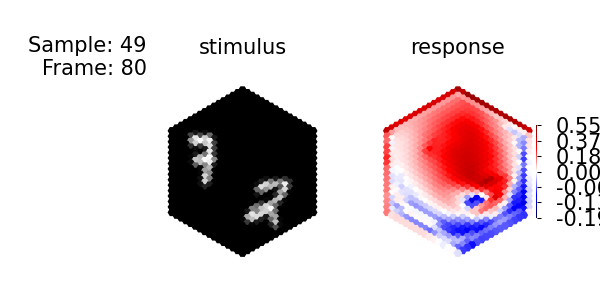

In [83]:
anim = flyvision.animations.activations.StimulusResponse(
    movie_input[None],
    responses[cell_type][:, 0][:, :, None]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::10])

In [84]:
# often, we are interested in the response of a single-cell from a specific type to make cell-by-cell comparisons.
# in our model, we can take the central cell as a proxy for all cells of the given type,
# because the network is conovolutional and we use parameter sharing. i.e. the function of the surrounding 
# cells of a given type is the exact same function of the central cell of the type
central_responses = responses.central

In [85]:
n_frames = movie_input.shape[0]
time = np.arange(0, n_frames * data.dt, data.dt)

In [86]:
colors = ensemble.task_error().colors

Look at all responses in an unstructured way.

<IPython.core.display.Javascript object>


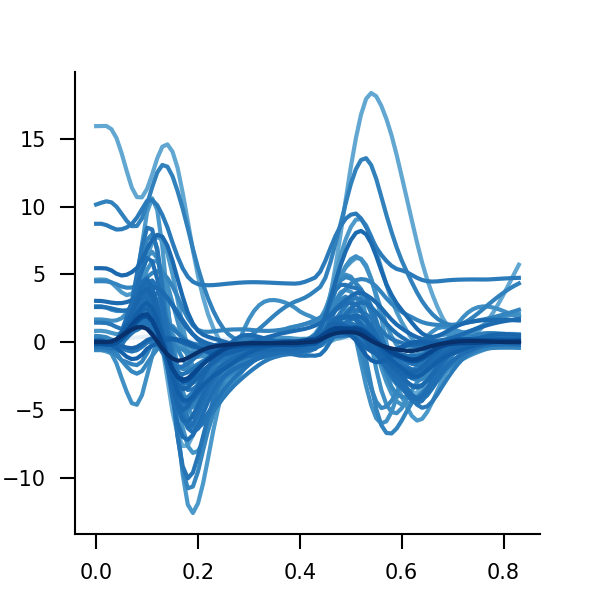

Text(0, 0.5, 'response (a.u.)')

In [87]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
for model_id, response in enumerate(central_responses[cell_type]):
    ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)

Let's look at responses by cluster.

In [88]:
cluster_indices = ensemble.cluster_indices(cell_type)
cluster_indices

{0: array([ 0,  1,  2,  3,  6,  9, 23, 24, 13, 12, 21, 22, 37, 19, 35, 30, 27,
        17, 29, 16, 36, 14, 20,  7, 18, 31, 42, 11, 47, 44, 48]),
 1: array([ 5, 26,  4, 33, 38, 40, 43]),
 2: array([ 8, 25, 10, 32, 34, 28, 45, 15, 39, 41, 46, 49])}

<IPython.core.display.Javascript object>


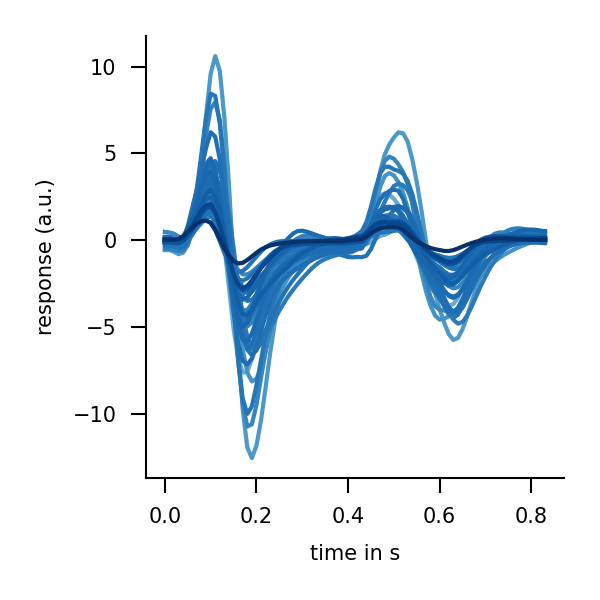

In [89]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)

for model_id in cluster_indices[0]:
    response = responses.central[cell_type][model_id]
    ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
fig.tight_layout()

<IPython.core.display.Javascript object>


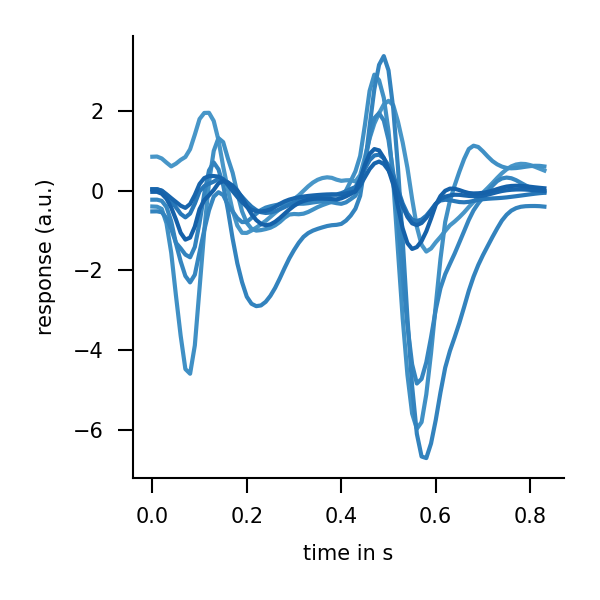

In [90]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)

for model_id in cluster_indices[1]:
    response = responses.central[cell_type][model_id]
    ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
fig.tight_layout()

<IPython.core.display.Javascript object>


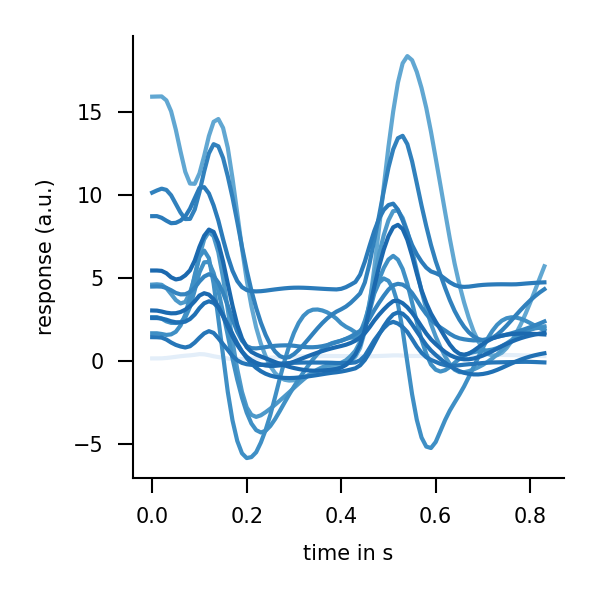

In [91]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)

for model_id in cluster_indices[2]:
    response = responses.central[cell_type][model_id]
    ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
fig.tight_layout()

For T4c, we know that one set of models is upwards tuning for T4c and one is downwards tuning -- lets observe that.
We choose the best upwards tuning model response and the best downwards tuning model response to compare them.
Notice for vertical movement, how cells in the first model (ON-motion upwards tuning) hyperpolarize at the position corresponding to the bottom of the white edges and depolarize at the position corresponding to the top.
In the second model, the opposite happens. 

In [103]:
cell_type = "T4c"

In [100]:
cluster_indices = ensemble.cluster_indices(cell_type)
cluster_indices

{0: array([ 0,  1,  2,  3,  6,  8,  9, 23, 24, 10, 12, 21, 22, 14, 34, 11]),
 1: array([ 5, 25,  4, 32, 15, 41, 46]),
 2: array([26, 27, 17, 29,  7, 44, 48]),
 3: array([13, 37, 33, 19, 35, 30, 16, 38, 36, 20, 18, 31, 28, 42, 45, 40, 39,
        47, 43, 49])}

<IPython.core.display.Javascript object>


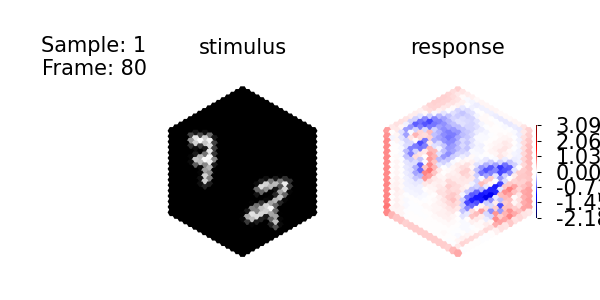

In [102]:
anim = flyvision.animations.activations.StimulusResponse(
    movie_input[None],
    responses[cell_type][[cluster_indices[0][0], cluster_indices[1][0]], 0][:, :, None]
)
anim.animate_in_notebook(frames = np.arange(anim.frames)[::10])

# Different example: random walk of blocks
If you want try getting responses to the ad-hoc dataset below.

In [ ]:
from flyvision.utils.dataset_utils import load_moving_mnist